## Exercise Set 2 for OSM 

### Dynamic Programming with John Stachurski

Exercises for the [OSM](https://bfi.uchicago.edu/osm) bootcamp dynamic programming section.

We will use the following libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe

### Exercise 1

Consider the setting of the [stochastic optimal growth model](https://lectures.quantecon.org/py/optgrowth.html), with the same notation and same assumptions on the primitives $u$, $f$, $\beta$ and $\phi$. 

Let $\mathscr C$ be all continuous bounded functions on $\mathbb R_+$.

Let $\sigma \in \Sigma$ be any feasible policy and let $U$ be the operator from $\mathscr C$ to itself defined by

$$ Uw(y) = u(\sigma(y)) + \beta \int w(f(y - \sigma(y))z) \phi(dz) \qquad (y \in \mathbb R_+)$$

Prove that $U$ is a contraction mapping with respect to the supremum distance.  Argue that the unique fixed point of $U$ in $\mathscr C$ is $v_\sigma$.

("Argue" means provide a sketch of a proof that contains the key ideas, plus some intuition.  Or give a complete, formal proof, if you can.)

### Answer:

Proof:

$$ \begin{align*} \bigg|U(w(y)) - U(w'(y)) \bigg| &= \bigg|U(\sigma(y)) + \beta \int w(f(y-\sigma)z)\phi(dz) - U(\sigma(y)) - \beta \int w'(f(y-\sigma)z)\phi(dz) \bigg|\\
&= \beta\quad\bigg|\int \big( w(f(y-\sigma)z) - w'(f(y-\sigma)z) \big) \phi(dz) \bigg|\\
&\leq \beta\int\bigg|\big( w(f(y-\sigma)z) - w'(f(y-\sigma)z) \big)\bigg|\quad\phi(dz)\\
&\leq \beta \sup_{j} \bigg|\big( w(f(y-\sigma)z) - w'(f(y-\sigma)z) \big)\bigg| = \beta \rho(w,w')
\end{align*} $$

Next, we know that it is a unique fixed point becasue it satisfies the three criteria. First, U is a contraction mapping from above. Second, the metric space is complete as it is a difference between the supremum of two bounded continuous functions. Third, we have specified that U maps from $\mathscr C$ to $\mathscr C$.

### Exercise 2

Notation and concepts continue from exercise 2.

Use the fact you proved in exercise 2, combined with piecewise linear interpolation method we used for the Bellman operator, to compute and plot good approximations of the value $v_\sigma$ of the policies

* $\sigma_1(y) = 0.95 y$
* $\sigma_2(y) = H(y) y$ where $H$ is the cdf of the lognormal $LN(0, 0.5)$ distribution.

For the latter use `scipy.stats.lognorm.cdf(y, 0.5)`

For the primitives, use the default specification in the `LogLinearOG` class from the [stochastic optimal growth model lecture](https://lectures.quantecon.org/py/optgrowth.html).

Plot your results, choosing grid and plotting dimensions to best illustrate the two functions.  Based on the plot alone, argue that neither of these policies is an optimal policy.

### Answer: 

We first look at the case where $\sigma_1(y) = 0.95 y$.

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
10           1.270e+00      5.356e-02         
20           7.766e-01      1.040e-01         
30           5.075e-01      1.556e-01         
40           3.362e-01      2.185e-01         
50           2.234e-01      2.766e-01         
60           1.485e-01      3.338e-01         
70           9.872e-02      3.891e-01         
80           6.563e-02      4.532e-01         
90           4.363e-02      5.043e-01         
100          2.901e-02      5.597e-01         
110          1.929e-02      6.108e-01         
120          1.282e-02      6.675e-01         
130          8.525e-03      7.339e-01         
140          5.668e-03      8.087e-01         
150          3.768e-03      8.790e-01         
160          2.505e-03      9.373e-01         
170          1.665e-03      9.914e-01         
180          1.107e-03      1.044e+00         
190          7.361e-04      1.098e+00         
200          4.

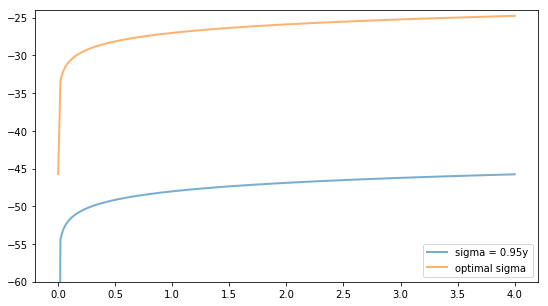

In [3]:
import numpy as np
from scipy.optimize import fminbound


def bellman_operator(w, grid, beta, u, f, shocks, Tw=None, compute_policy=0):
    """
    The approximate Bellman operator, which computes and returns the
    updated value function Tw on the grid points.  An array to store
    the new set of values Tw is optionally supplied (to avoid having to
    allocate new arrays at each iteration).  If supplied, any existing data in 
    Tw will be overwritten.

    Parameters
    ----------
    w : array_like(float, ndim=1)
        The value of the input function on different grid points
    grid : array_like(float, ndim=1)
        The set of grid points
    beta : scalar
        The discount factor
    u : function
        The utility function
    f : function
        The production function
    shocks : numpy array
        An array of draws from the shock, for Monte Carlo integration (to
        compute expectations).
    Tw : array_like(float, ndim=1) optional (default=None)
        Array to write output values to
    compute_policy : Boolean, optional (default=False)
        Whether or not to compute policy function

    """
    # === Apply linear interpolation to w === #
    w_func = lambda x: np.interp(x, grid, w)

    # == Initialize Tw if necessary == #
    if Tw is None:
        Tw = np.empty_like(w)

    if compute_policy:
        sigma = np.empty_like(w)

    # == set Tw[i] = max_c { u(c) + beta E w(f(y  - c) z)} == #
    for i, y in enumerate(grid):
        def objective(c):
            return - u(c) - beta * np.mean(w_func(f(y - c) * shocks))
        #c_star = fminbound(objective, 1e-10, y)
        if compute_policy:
            sigma[i] = c_star
        Tw[i] = - objective(0.95 * y)

    if compute_policy:
        return Tw, sigma
    else:
        return Tw

class LogLinearOG:
    """
    Log linear optimal growth model, with log utility, CD production and
    multiplicative lognormal shock, so that

        y = f(k, z) = z k^alpha

    with z ~ LN(mu, s).

    The class holds parameters and true value and policy functions.
    """

    def __init__(self, alpha=0.4, beta=0.96, mu=0, s=0.1):

        self.alpha, self.beta, self.mu, self.s = alpha, beta, mu, s 

        # == Some useful constants == #
        self.ab = alpha * beta
        self.c1 = np.log(1 - self.ab) / (1 - beta)
        self.c2 = (mu + alpha * np.log(self.ab)) / (1 - alpha)
        self.c3 = 1 / (1 - beta)
        self.c4 = 1 / (1 - self.ab)

    def u(self, c):
        " Utility "
        return np.log(c)

    def u_prime(self, c):
        return 1 / c

    def f(self, k):
        " Deterministic part of production function.  "
        return k**self.alpha

    def f_prime(self, k):
        return self.alpha * k**(self.alpha - 1)

    def c_star(self, y):
        " True optimal policy.  "
        return (1 - self.alpha * self.beta) * y

    def v_star(self, y):
        " True value function. "
        return self.c1 + self.c2 * (self.c3 - self.c4) + self.c4 * np.log(y)

lg = LogLinearOG()
# == Unpack parameters / functions for convenience == #
alpha, beta, mu, s = lg.alpha, lg.beta, lg.mu, lg.s
v_star = lg.v_star

grid_max = 4         # Largest grid point
grid_size = 200      # Number of grid points
shock_size = 250     # Number of shock draws in Monte Carlo integral

grid = np.linspace(1e-5, grid_max, grid_size)
shocks = np.exp(mu + s * np.random.randn(shock_size))

import matplotlib.pyplot as plt

from quantecon import compute_fixed_point

Tw = np.empty(len(grid))
initial_w = 5 * np.log(grid)
w = 5 * np.log(grid)

# Turn the Bellman operator into a function of one variable
T = lambda w: bellman_operator(w,
                               grid,
                               beta,
                               np.log,
                               lambda k: k**alpha,
                               shocks,
                               compute_policy=False)

v_star_approx = compute_fixed_point(T, initial_w,
                                    error_tol=1e-5,  # error_tol
                                    max_iter=500,   # max_iter
                                    verbose=2,  # verbose
                                    print_skip=10,     # print_skip
                                    method='iteration')
plt.clf()
fig, ax = plt.subplots(figsize=(9, 5))
ax.set_ylim(-60, -24)
ax.plot(grid, v_star_approx, lw=2, alpha=0.6, label='sigma = 0.95y')
ax.plot(grid, v_star(grid), lw=2, alpha=0.6, label='optimal sigma')
ax.legend(loc='lower right')
plt.show()

From this graph, we can see that for all y, the value with the optimal sigma is greater than when we specify a non-optimal sigma. Next, we look at the case where $\sigma_2(y) = H(y) y$ where $H$ is the cdf of the lognormal $LN(0, 0.5)$ distribution.

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
10           1.334e+00      3.173e-01         
20           6.379e-01      6.343e-01         
30           4.240e-01      9.511e-01         
40           2.819e-01      1.283e+00         
50           1.874e-01      1.671e+00         
60           1.246e-01      2.011e+00         
70           8.283e-02      2.329e+00         
80           5.507e-02      2.682e+00         
90           3.661e-02      2.999e+00         
100          2.434e-02      3.325e+00         
110          1.618e-02      3.650e+00         
120          1.076e-02      3.960e+00         
130          7.152e-03      4.275e+00         
140          4.755e-03      4.590e+00         
150          3.161e-03      4.904e+00         
160          2.102e-03      5.221e+00         
170          1.397e-03      5.586e+00         
180          9.290e-04      5.960e+00         
190          6.176e-04      6.293e+00         
200          4.

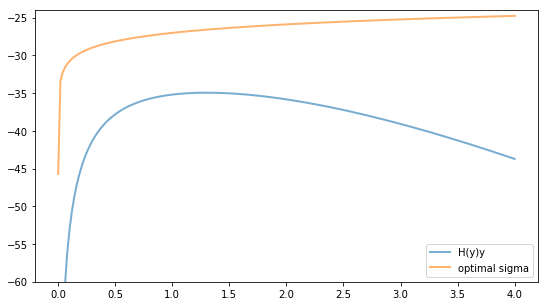

In [2]:
import numpy as np
from scipy.optimize import fminbound
import scipy

def bellman_operator(w, grid, beta, u, f, shocks, Tw=None, compute_policy=0):
    """
    The approximate Bellman operator, which computes and returns the
    updated value function Tw on the grid points.  An array to store
    the new set of values Tw is optionally supplied (to avoid having to
    allocate new arrays at each iteration).  If supplied, any existing data in 
    Tw will be overwritten.

    Parameters
    ----------
    w : array_like(float, ndim=1)
        The value of the input function on different grid points
    grid : array_like(float, ndim=1)
        The set of grid points
    beta : scalar
        The discount factor
    u : function
        The utility function
    f : function
        The production function
    shocks : numpy array
        An array of draws from the shock, for Monte Carlo integration (to
        compute expectations).
    Tw : array_like(float, ndim=1) optional (default=None)
        Array to write output values to
    compute_policy : Boolean, optional (default=False)
        Whether or not to compute policy function

    """
    # === Apply linear interpolation to w === #
    w_func = lambda x: np.interp(x, grid, w)

    # == Initialize Tw if necessary == #
    if Tw is None:
        Tw = np.empty_like(w)

    if compute_policy:
        sigma = np.empty_like(w)

    # == set Tw[i] = max_c { u(c) + beta E w(f(y  - c) z)} == #
    for i, y in enumerate(grid):
        def objective(c):
            return - u(c) - beta * np.mean(w_func(f(y - c) * shocks))
        #c_star = fminbound(objective, 1e-10, y)
        if compute_policy:
            sigma[i] = c_star
        Tw[i] = - objective(scipy.stats.lognorm.cdf(y, 0.5) * y)

    if compute_policy:
        return Tw, sigma
    else:
        return Tw

class LogLinearOG:
    """
    Log linear optimal growth model, with log utility, CD production and
    multiplicative lognormal shock, so that

        y = f(k, z) = z k^alpha

    with z ~ LN(mu, s).

    The class holds parameters and true value and policy functions.
    """

    def __init__(self, alpha=0.4, beta=0.96, mu=0, s=0.1):

        self.alpha, self.beta, self.mu, self.s = alpha, beta, mu, s 

        # == Some useful constants == #
        self.ab = alpha * beta
        self.c1 = np.log(1 - self.ab) / (1 - beta)
        self.c2 = (mu + alpha * np.log(self.ab)) / (1 - alpha)
        self.c3 = 1 / (1 - beta)
        self.c4 = 1 / (1 - self.ab)

    def u(self, c):
        " Utility "
        return np.log(c)

    def u_prime(self, c):
        return 1 / c

    def f(self, k):
        " Deterministic part of production function.  "
        return k**self.alpha

    def f_prime(self, k):
        return self.alpha * k**(self.alpha - 1)

    def c_star(self, y):
        " True optimal policy.  "
        return (1 - self.alpha * self.beta) * y

    def v_star(self, y):
        " True value function. "
        return self.c1 + self.c2 * (self.c3 - self.c4) + self.c4 * np.log(y)

lg = LogLinearOG()
# == Unpack parameters / functions for convenience == #
alpha, beta, mu, s = lg.alpha, lg.beta, lg.mu, lg.s
v_star = lg.v_star

grid_max = 4         # Largest grid point
grid_size = 200      # Number of grid points
shock_size = 250     # Number of shock draws in Monte Carlo integral

grid = np.linspace(1e-5, grid_max, grid_size)
shocks = np.exp(mu + s * np.random.randn(shock_size))

import matplotlib.pyplot as plt

from quantecon import compute_fixed_point

Tw = np.empty(len(grid))
initial_w = 5 * np.log(grid)

# Turn the Bellman operator into a function of one variable
T = lambda w: bellman_operator(w,
                               grid,
                               beta,
                               np.log,
                               lambda k: k**alpha,
                               shocks,
                               compute_policy=False)

v_star_approx = compute_fixed_point(T, initial_w,
                                    error_tol=1e-5,  # error_tol
                                    max_iter=500,   # max_iter
                                    verbose=2,  # verbose
                                    print_skip=10,     # print_skip
                                    method='iteration')
plt.clf()
fig, ax = plt.subplots(figsize=(9, 5))
ax.set_ylim(-60, -24)
ax.plot(grid, v_star_approx, lw=2, alpha=0.6, label='H(y)y')
ax.plot(grid, v_star(grid), lw=2, alpha=0.6, label='optimal sigma')
ax.legend(loc='lower right')
plt.show()

From this graph, we can see that for all y, the value with the optimal sigma is greater than when we specify a non-optimal sigma.